In [199]:
import pandas as pd
import numpy as np
import datetime

import os

from pandas.io.json import json_normalize

from datetime import datetime
from pytz import timezone

Get step data

In [203]:
dir_path = 'health/Data/'
matching_phrase = 'steps-'

date = []
value = []

for file in listdir(dir_path):
    if matching_phrase in file:
        with open(dir_path + file) as f:
            data = json.load(f)
            df = pd.json_normalize(data)
            df.columns = ['date', 'value']

            for i in df['date']:
                date.append(i)

            for i in df['value']:
                value.append(i)

df = pd.DataFrame(list(zip(date, value)), 
   columns =['date', 'value'])

Timezone is in UTC, so must convert to local time. Also, date interval is by minute, so need to aggregate to daily level.

In [204]:
# convert time data to local timezone (CST)
df['date'] = pd.to_datetime(df['date']).dt.tz_localize('America/Chicago', 
                                                       ambiguous = 'NaT',
                                                       nonexistent='shift_forward')

# remove time from date for grouping
df['day'] = pd.to_datetime(df['date']).dt.date

# convert value to numeric
df['value'] = pd.to_numeric(df['value'], errors = 'coerce')

steps = df.groupby(["day"]).agg(steps=("value","sum")).reset_index()

steps

,day,steps
0,2018-02-09,10
1,2018-02-10,7964
2,2018-02-11,7582
3,2018-02-12,12535
4,2018-02-13,18006
...,...,...
625,2019-11-04,0
626,2019-11-05,32
627,2019-11-06,0
628,2019-11-07,0


Gather heart rate data from files

In [216]:
matching_phrase = 'heart'

date = []
value = []

for file in listdir(dir_path):
    if matching_phrase in file:
        with open(dir_path + file) as f:
            data = json.load(f)
            df = pd.json_normalize(data)
            # this json has four columns and the JSON is formatted differently than the steps data
            df.columns = ['date_utc', 'date', 'average_hr', 'error']

            for i in df['date']:
                date.append(i)

            for i in df['average_hr']:
                value.append(i)

df = pd.DataFrame(list(zip(date, value)), 
   columns =['date', 'average_hr'])

In [217]:
# gather only dates with data
heart_rate = df[df['date'].notna()]
heart_rate

,date,average_hr
1,02/09/18,58.000000
2,02/10/18,59.029068
3,02/11/18,62.038370
4,02/12/18,62.245052
5,02/13/18,60.857355
...,...,...
622,10/23/19,55.536179
623,10/24/19,55.587471
624,10/25/19,56.973512
625,10/26/19,57.959826


In [229]:
matching_phrase = 'sleep'

date = []
start_time = []
end_time = []
duration = []
asleep_min = []
awake_min = []
rem_min = []
rem_30_day_avg = []


for file in listdir(dir_path):
    if matching_phrase in file:
        with open(dir_path + file) as f:
            data = json.load(f)
            df = pd.json_normalize(data)
            # this json has several levels of nested data, select only those desired for analysis later
            df = df[['dateOfSleep', 'startTime', 'endTime','duration','minutesAsleep','minutesAwake',
               'levels.summary.rem.minutes','levels.summary.rem.thirtyDayAvgMinutes']]
            
            for i in df['dateOfSleep']:
                date.append(i)
                
            for i in df['startTime']:
                start_time.append(i)
                
            for i in df['endTime']:
                end_time.append(i)
                
            for i in df['duration']:
                duration.append(i)
                
            for i in df['minutesAsleep']:
                asleep_min.append(i)
                
            for i in df['minutesAwake']:
                awake_min.append(i)

            for i in df['levels.summary.rem.minutes']:
                rem_min.append(i)
                
            for i in df['levels.summary.rem.thirtyDayAvgMinutes']:
                rem_30_day_avg.append(i)
                
                
df = pd.DataFrame(list(zip(date, start_time, end_time, duration, asleep_min, awake_min, rem_min, rem_30_day_avg)), 
   columns =['date', 'start_time', 'end_time', 'duration_min', 'asleep_min', 'awake_min', 'rem_min', 'rem_30_day_avg'])

# duration is in ms (divide by 60000 to obtain minutes)
df['duration_min'] = df['duration_min'] / 60000

In [230]:
df

,date,start_time,end_time,duration_min,asleep_min,awake_min,rem_min,rem_30_day_avg
0,2018-03-08,2018-03-07T21:54:00.000,2018-03-08T07:00:30.000,546.0,502,44,83.0,109.0
1,2018-03-06,2018-03-05T21:36:00.000,2018-03-06T06:21:00.000,525.0,482,43,138.0,107.0
2,2018-03-03,2018-03-02T22:47:30.000,2018-03-03T07:50:30.000,543.0,481,62,142.0,103.0
3,2018-02-28,2018-02-27T21:52:00.000,2018-02-28T06:21:30.000,509.0,474,35,102.0,103.0
4,2018-02-26,2018-02-25T21:57:00.000,2018-02-26T06:25:30.000,508.0,444,64,57.0,109.0
...,...,...,...,...,...,...,...,...
498,2019-10-04,2019-10-03T20:47:00.000,2019-10-04T06:17:00.000,570.0,460,110,96.0,92.0
499,2019-10-03,2019-10-03T01:39:00.000,2019-10-03T06:28:00.000,289.0,255,34,69.0,103.0
500,2019-10-02,2019-10-02T22:00:30.000,2019-10-02T23:47:00.000,106.0,102,4,NaN,NaN
501,2019-10-02,2019-10-01T22:27:00.000,2019-10-02T06:34:30.000,487.0,433,54,112.0,94.0


In [ ]:
df['date'] = pd.to_datetime(df['date']).dt.tz_localize('America/Chicago', 
                                                       ambiguous = 'NaT',
                                                       nonexistent='shift_forward')

# remove time from date for grouping
df['day'] = pd.to_datetime(df['date']).dt.date

# convert value to numeric
df['value'] = pd.to_numeric(df['value'], errors = 'coerce')

steps = df.groupby(["day"]).agg(steps=("value","sum")).reset_index()

steps

In [94]:
with open('health/Data/complete_steps.json') as f:
    data = json.load(f)

In [107]:
with open('health/Data/resting_heart_rate-2020-02-08.json') as f:
    data = json.load(f)

In [104]:
with open('health/Data/resting_heart_rate-2020-02-08.json') as f:
    data = json.load(f)
    stepsdf = pd.json_normalize(data)
    stepsdf

In [105]:
stepsdf

,dateTime,value.date,value.value,value.error
0,02/08/20 00:00:00,None,0.0,0.0
1,02/09/20 00:00:00,None,0.0,0.0
2,02/10/20 00:00:00,None,0.0,0.0
3,02/11/20 00:00:00,None,0.0,0.0
4,02/12/20 00:00:00,None,0.0,0.0
...,...,...,...,...
360,02/02/21 00:00:00,None,0.0,0.0
361,02/03/21 00:00:00,None,0.0,0.0
362,02/04/21 00:00:00,None,0.0,0.0
363,02/05/21 00:00:00,None,0.0,0.0


Open all json files for a particular metric, parse values and write to a single pandas dataframe.

In [97]:
from pandas.io.json import json_normalize

path = 'health/Data/'

date = []
steps = []

for file in listdir('health/Data/'):
    if 'steps-' in file:
        # do something
        with open(path + file) as f:
            data = json.load(f)
            stepsdf = pd.json_normalize(data)
            stepsdf.columns = ['date', 'steps']
            
            for i in stepsdf['date']:
                date.append(i)
            
            for i in stepsdf['steps']:
                steps.append(i)
            
df_top100 = pd.DataFrame(list(zip(date, steps)), 
   columns =['date', 'steps'])


In [98]:
df_top100

,date,steps
0,02/09/18 22:21:00,0
1,02/09/18 22:22:00,0
2,02/09/18 22:23:00,0
3,02/09/18 22:24:00,0
4,02/09/18 22:26:00,0
...,...,...
730586,12/16/19 14:11:00,0
730587,12/16/19 14:27:00,0
730588,12/16/19 14:31:00,0
730589,12/16/19 14:32:00,0


In [131]:
def fitbit_json_to_pandas(dir_path, matching_phrase):
    """Flatten json object with nested keys into a single level.
        Args:
            nested_json: A nested json object.
            exclude: Keys to exclude from output.
        Returns:
            The flattened json object if successful, None otherwise.
    """
    from pandas.io.json import json_normalize

    date = []
    value = []

    for file in listdir(dir_path):
        if matching_phrase in file:
            # do something
            with open(dir_path + file) as f:
                data = json.load(f)
                df = pd.json_normalize(data)
                df.columns = ['date', 'value']

                for i in df['date']:
                    date.append(i)

                for i in df['value']:
                    value.append(i)
            
    json_df = pd.DataFrame(list(zip(date, value)), 
       columns =['date', 'value'])
        
    return json_df

In [195]:
df = fitbit_json_to_pandas('health/Data/', 'steps-')

In [196]:
# convert time data to local timezone (CST)
from datetime import datetime
from pytz import timezone
df['date'] = pd.to_datetime(df['date']).dt.tz_localize('America/Chicago', 
                                                       ambiguous = 'NaT',
                                                       nonexistent='shift_forward')

In [197]:
# remove time from date for grouping
df['day'] = pd.to_datetime(df['date']).dt.date

# convert value to numeric
df['value'] = pd.to_numeric(df['value'], errors = 'coerce')

steps = df.groupby(["day"]).agg(steps=("value","sum")).reset_index()

steps

,day,steps
0,2018-02-09,10
1,2018-02-10,7964
2,2018-02-11,7582
3,2018-02-12,12535
4,2018-02-13,18006
...,...,...
625,2019-11-04,0
626,2019-11-05,32
627,2019-11-06,0
628,2019-11-07,0


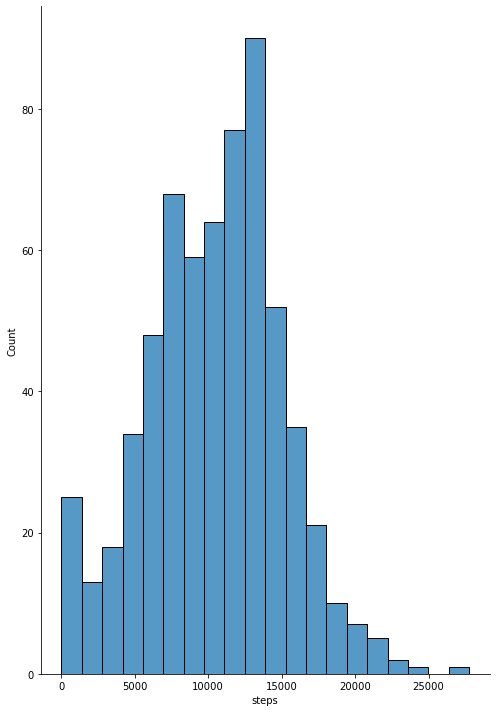

In [198]:
import seaborn as sns
sns.displot(data=steps, x='steps', height=10, aspect=.7)

In [95]:
with open('health/Data/steps-2019-03-05.json') as f:
    data_one = json.load(f)

In [96]:
pd.json_normalize(data_one)

,dateTime,value
0,03/05/19 06:00:00,0
1,03/05/19 06:01:00,0
2,03/05/19 06:02:00,0
3,03/05/19 06:03:00,0
4,03/05/19 06:04:00,0
...,...,...
34405,04/04/19 04:55:00,0
34406,04/04/19 04:56:00,0
34407,04/04/19 04:57:00,0
34408,04/04/19 04:58:00,0


In [82]:
from pandas.io.json import json_normalize
stepsdf = pd.json_normalize(data_one)
stepsdf.columns = ['date', 'steps']
#stepsdf = stepsdf.set_index(stepsdf['date'])
stepsdf

,date,steps
0,03/05/19 06:00:00,0
1,03/05/19 06:01:00,0
2,03/05/19 06:02:00,0
3,03/05/19 06:03:00,0
4,03/05/19 06:04:00,0
...,...,...
34405,04/04/19 04:55:00,0
34406,04/04/19 04:56:00,0
34407,04/04/19 04:57:00,0
34408,04/04/19 04:58:00,0
